# TODO
- Rolling window views.
- Extreme amount extraction.
- True income vs loaned money display.
- Code refactoring.

In [61]:
%matplotlib inline

In [62]:
from IPython.display import display
from IPython.display import clear_output
from ipywidgets import *
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import locale

# Settings

In [63]:
locale.setlocale(locale.LC_ALL, 'en_GB.utf8');

# Generic functions

In [64]:
def amount_to_str(x):
    x = float(x)
    x /= 100.0
    return locale.format("%.2f", x, grouping=True)

In [65]:
def get_period(df,
               start=dt.date.today().replace(year=1900),
               end=dt.date.today()):
    period = df.loc[df.date >= start]
    return period.loc[period.date <= end]

# Data

In [66]:
df = pd.read_csv('afschriften.csv')

In [67]:
cats = pd.read_csv('categories.csv')

# Preprocessing
###### Column renaming

In [68]:
renamings = {
    'Datum': 'date',
    'Naam / Omschrijving': 'name',
    'Rekening': 'account_from',
    'Tegenrekening': 'account_to',
    'Code': 'code',
    'Af Bij': 'sign',
    'Bedrag (EUR)': 'amount',
    'MutatieSoort': 'device',
    'Mededelingen': 'note',
}
df = df.rename(columns=renamings)

###### Date parsing

In [69]:
# Parse the date column to datetimes and set as index.
df.date = pd.to_datetime(df.date, format='%Y%m%d')

In [70]:
df['week'] = df.date.apply(lambda x:x.week)

In [71]:
# df['month'] = df.date.apply(lambda x:str(x.strftime("%B")))
df['month'] = df.date.apply(lambda x:x.month)

In [72]:
df['year'] = df.date.apply(lambda x:x.year)

###### Account to parsing

In [73]:
df.account_to = df.account_to.replace(np.nan, '-')

###### Sign and amount parsing

In [74]:
# Transform the sign column to symbols.
df.sign = df.sign.apply(lambda sign: '+' if sign == 'Bij' else '-')

In [75]:
# Transform amount column from str to float.
df.amount = df.amount.replace({',': '.'}, regex=True).astype(np.float64)

In [76]:
# Transform amount column from float to int, without losing the cents.
df.amount = df.amount.apply(lambda x: x * 100).astype(int)

In [77]:
# Apply the symbol in the sign column to the amounts.
f = lambda x: x.amount if x.sign == '+' else -x.amount
df.amount = df[['sign', 'amount']].apply(f, axis=1, broadcast=True)
df.amount = df.amount.astype(int)

In [78]:
df['balance'] = df.amount.cumsum()

###### Finished

In [79]:
display(df.head())

,date,name,account_from,account_to,code,sign,amount,device,note,week,month,year,balance
0,2017-04-04,ALBERT HEIJN 1649 LEIDEN NLD,NL68INGB0008657598,-,BA,-,-1011,Betaalautomaat,Pasvolgnr:005 03-04-2017 21:43 Transactie:62V5...,14,4,2017,-1011
1,2017-04-04,359 Lidl Leiden LEIDEN NLD,NL68INGB0008657598,-,BA,-,-149,Betaalautomaat,Pasvolgnr:005 03-04-2017 15:04 Transactie:49C2...,14,4,2017,-1160
2,2017-04-03,Hr MHS de Buck,NL68INGB0008657598,NL92INGB0004737590,GT,+,2086,Internetbankieren,Naam: Hr MHS de Buck Omschrijving: Wiebetaaltw...,14,4,2017,926
3,2017-04-03,Albert Heijn 1649 LEIDEN NLD,NL68INGB0008657598,-,BA,-,-195,Betaalautomaat,Pasvolgnr:005 03-04-2017 08:46 Transactie:33S3...,14,4,2017,731
4,2017-04-03,118606 SON NLD,NL68INGB0008657598,-,BA,-,-180,Betaalautomaat,Pasvolgnr:005 03-04-2017 10:49 Transactie:36E7...,14,4,2017,551


# Categorisation
## Categories

In [80]:
def create_category_overview(df, cats):
    df = df.loc[:, ('account_to', 'amount')]
    df = pd.merge(cats, df, on='account_to').drop('account_to', axis=1)
    df = df.groupby('category').sum()
    return df

def print_category_overview(overview):
    overview = overview.sort_values(by='amount')
    overview.amount = overview.amount.apply(amount_to_str)
    display(overview)

## Uncategorised

In [81]:
def print_uncategorised(df):
    idxs = ~df.account_to.isin(cats.account_to), ('name', 'account_to', 'amount')
    display(df.loc[idxs])

# Overview: income & expense

In [82]:
def describe(s):
    """Creates a custom description of a series.
    """
    return {
        'total': s.sum(),
        'positive': s.loc[s >= 0].sum(),
        'negative': s.loc[s < 0].sum(),
        'min': s.min(),
        'max': s.max(),
        'avg': s.mean(),
        'median': s.median(),
#         'mode': s.mode(),
        'count': s.count(),
    }

# TODO: fix formatting with plus/minus signs.
def print_description(d, name):
    """Prints a description. 
    
    Naming is based on the assumption that
    the description describes a revenue stream.
    """
    # All amounts to str representation.
    d = {k: v if k == 'count' else amount_to_str(v) for k, v in d.items()}
    
    print('--- {} ---'.format(name))
    print('expense {}'.format(d['negative']))
    print('revenue  {}'.format(d['positive']))
    print('income  {}'.format(d['total']))
    print()
    print('count    {}'.format(d['count']))
    print('min     {}'.format(d['min']))
    print('max      {}'.format(d['max']))
    print('avg     {}'.format(d['avg']))
    print('median  {}'.format(d['median']))
#     print('mode    {:.0f}'.format(d['mode']))

In [83]:
def summed_mutation_overview(period):
    """Sums all mutations per account_to and adds name to each account.
    
    df: Entire history in a DataFrame.
    start: DateTime for start (inclusive) of the period.
    end: DateTime for end (inclusive) of the period.
    Returns: DataFrame with columns 'account_to, name, amount'. Amounts
        are summed by account_to. The first name found for an account_to
        in the df is assigned as a value in the respective name column. 
        The only exception to this is the account_to with value '-', this
        gets the name '-'.
    """
    # Combine amounts with respect to the account_to and add a name.
    accountto_amount = period[['account_to', 'amount']].groupby('account_to', as_index=False).sum()
    accountto_name = period[['account_to', 'name']].groupby('account_to', as_index=False).first()
    overview = pd.merge(accountto_name, accountto_amount, how='left', on='account_to')
    # Assigning name '-' to account_to == '-'.
    overview.loc[overview.account_to == '-', 'name'] = '-'
    # Prettify and sort.
    overview = overview.sort_values(by=['amount'])
    overview.amount = overview.amount.apply(amount_to_str)
    return overview

## Current month

In [84]:
def current_month_start():
    start = dt.date.today()
    if start.day > 25:
        start += dt.timedelta(7)
    return start.replace(day=1)

In [85]:
period = get_period(df, current_month_start())

### Description

In [86]:
print_description(describe(period.amount), "CURRENT MONTH")

--- CURRENT MONTH ---
expense -478.68
revenue  332.86
income  -145.82

count    18
min     -328.18
max      275.00
avg     -8.10
median  -2.48


### Account mutations

In [87]:
summed_mutation_overview(period)

,account_to,name,amount
4,NL87RABO0313431000,STICHTING DUWO,-328.18
1,NL04INGB0749085940,Manouk,-63.00
0,-,-,-54.50
2,NL36ABNA0977746623,thierry van den oord,-8.00
5,NL92INGB0004737590,Hr MHS de Buck,20.86
3,NL61INGB0003926452,G A M van Rooijen e/o C C M van Rooijen-de Gier,287.00


### Category mutations

In [88]:
print_category_overview(create_category_overview(period, cats))

,amount
category,
rent,-328.18
other,-54.50
family and friends,236.86


#### Uncategorised

In [89]:
print_uncategorised(period)

,name,account_to,amount


## Last 4 weeks

## All

### Description

In [90]:
print_description(describe(df.amount), "TOTAL")

--- TOTAL ---
expense -158,737.27
revenue  157,897.35
income  -839.92

count    4644
min     -10,438.87
max      10,438.87
avg     -0.18
median  -4.34


### Account mutations

In [91]:
summed_mutation_overview(df)

,account_to,name,amount
0,-,-,"-39,257.51"
285,NL87RABO0313431000,STICHTING DUWO,"-12,218.40"
265,NL71RABO0103257217,UNIV LEIDEN COLLEGEGELDE,"-5,841.00"
41,238656853,KN: 6551312003671,"-4,643.00"
83,3926452,G EN C VAN ROOIJEN-DE GIER,"-4,215.10"
3,103257217,KN: 130000219907,"-3,606.00"
283,NL87INGB0676416217,Anderzorg,"-3,241.92"
254,NL63INGB0666647585,"Hr JR Bril, Mw RJ Bril-Lennips","-2,100.00"
86,397026080,KN: 930104708130,"-1,737.00"
55,285033018,KN: 428037000446,"-1,734.12"


### Category mutations

In [92]:
print_category_overview(create_category_overview(df, cats))

,amount
category,
other,"-39,257.51"
rent,"-12,218.40"
travel,-294.91
telecom,-60.00
tax,"4,313.00"
family and friends,"12,494.65"
student loan,"28,571.83"


#### Uncategorised

In [93]:
print_uncategorised(df)

,name,account_to,amount
62,Patcho,NL64RABO0132239973,-1295
95,Bart Heijke,NL65INGB0001355880,-1000
133,Anderzorg,NL87INGB0676416217,-91728
139,DW DE MUINCK KEIZER,NL71ABNA0580426815,600
140,JRM MARTENS,NL79ABNA0576503312,300
142,C VAN DORP,NL54ABNA0459575791,-800
146,Stichting Derdengelden Pink Tie,NL82ABNA0575812036,-10500
149,Hr B Heijke,NL65INGB0001355880,1750
150,Hr B Rijnders,NL96INGB0008695021,1750
168,bol.com b.v.,NL27INGB0000026500,-1495


##### Heatmaps

In [94]:
pt_ym_amount = df[['year','month','amount']].groupby(['year','month'], as_index=False).sum()
pt_ym_amount = pt_ym_amount.pivot('year','month','amount')
# display(pt_ym_amount)

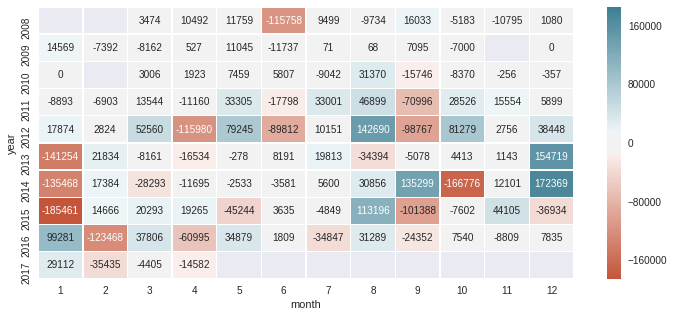

In [95]:
cmap = sns.diverging_palette(20, 220, sep=20, as_cmap=True)
fig, ax = plt.subplots(figsize=(12,5)) 
sns.heatmap(pt_ym_amount, linewidth=.4, fmt='.0f', annot=True, cmap=cmap, ax=ax);

In [98]:
pt_ym_balance = df[['year','month','balance']].groupby(['year','month'], as_index=False).sum()
pt_ym_balance = pt_ym_balance.pivot('year','month','balance')
#display(pt_ym_balance)

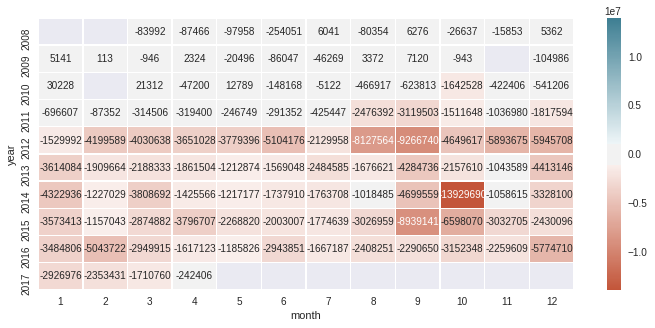

In [97]:
cmap = sns.diverging_palette(20, 220, sep=20, as_cmap=True)
fig, ax = plt.subplots(figsize=(12,5)) 
sns.heatmap(pt_ym_balance, linewidth=.4, fmt='.0f', annot=True, cmap=cmap, ax=ax);